In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

In [ ]:
def clean_leading_zeros(df):
    
    if pd.to_datetime(df.loc[1,'Timestamp']) - pd.to_datetime(df.loc[0,'Timestamp']) >= pd.Timedelta(1, "s") :
        Leading_Zeros = df.loc[~(df.drop(['Timestamp'],axis=1)==0).all(axis=1)]
        if Leading_Zeros.empty:
            return Leading_Zeros
        else:
            print('There are leading zeros till ',Leading_Zeros.index[0])
            return df.loc[Leading_Zeros.index[0]::,:]
    else:
        return df

def load_ACC_files(x,MainPath):
    
    File = str(x) + '/' + str(x) + '.csv' 
    Data = pd.read_csv(MainPath + File,usecols = ['Timestamp','X','Y','Z'])
    print('--------------------------------------------------')
    print('\nFile: {} with Dimensions {}'.format(x,Data.shape))
    print('Data in the file:')
    print(Data.head(3))
    
    Data = clean_leading_zeros(Data)
    print('\nData After Cleaning Leading Zeros:')
    print(Data.head(3)) 
    
    print('Dimensions after removing leading empty rows: ',Data.shape)
    Data = Data.reset_index(drop=True)
          
    return Data    
    

def feature_extraction_ACC(Data,Unique_Time,freq,windows):
    
    if windows > 0:
        
        Norm = np.sqrt(np.sum(np.square(Data.iloc[:,1:4]),axis=1))
        t = pd.to_datetime(Data.loc[freq:Unique_Time*freq-1:freq,'Timestamp'],format="%d/%m/%Y %H:%M:%S.%f")
        vedba = Norm.rolling(window=windows,center=True).std().dropna(axis=0).loc[0:(Unique_Time*freq)-1:freq]
        means = Data.iloc[:,1:4].rolling(window=windows,center=True).mean().dropna(axis=0).loc[0:(Unique_Time*freq)-1:freq]
        maxes = Data.iloc[:,1:4].rolling(window=windows,center=True).max().dropna(axis=0).loc[0:(Unique_Time*freq)-1:freq]
        mins = Data.iloc[:,1:4].rolling(window=windows,center=True).min().dropna(axis=0).loc[0:(Unique_Time*freq)-1:freq]
        std = Data.iloc[:,1:4].rolling(window=windows,center=True).std().dropna(axis=0).loc[0:(Unique_Time*freq)-1:freq]
    
    else:
        Values = Data.iloc[0:Unique_Time*freq,1:4].to_numpy()
        Norm = np.sqrt(np.sum(np.square(Values),axis=1))
        t = pd.to_datetime(Data.loc[0:(Unique_Time*freq) - 1:freq,'Timestamp'],format="%d/%m/%Y %H:%M:%S.%f")
        vedba = np.std(Norm.reshape(Unique_Time,freq),axis=1)
        means = np.mean(Values.reshape((Unique_Time,freq,3)),axis=1)
        maxes = np.max(Values.reshape((Unique_Time,freq,3)),axis=1)
        mins = np.min(Values.reshape((Unique_Time,freq,3)),axis=1)
        std = np.std(Values.reshape((Unique_Time,freq,3)),axis=1)
    
    return t,vedba,means,std,maxes,mins

In [10]:
Groups = ['ZU_2021_1','ZU_2021_2','NQ_2021_1','RW_2021_1']
Group_freq = [10,50,50,10]

for k in range(len(Groups)):
    
    MainPath = 'MoveComm2021/' + str(Groups[k]) + '/GPS/'
    SavePath = 'Processed Data/' + str(Groups[k]) + '/ACC/'

    paths = os.listdir(MainPath)
    paths = [i for i in paths if 'DS_Store' not in i]
    
    os.makedirs(SavePath, exist_ok=True)
    
    freq = int(Group_freq[k])
    windows = 2*freq
    
    for y in paths:


        Data = load_ACC_files(y,MainPath)
        
        Unique_Time= Data.shape[0]//freq
        print('\nUnique Times: ',Unique_Time)

        print('Dimension of ACC Values After Considering Unique Times: ({},{}) '.format(Unique_Time*freq,4))

        t,vedba,means,std,maxes,mins = feature_extraction_ACC(Data,Unique_Time,freq,windows)


        Features_Data = pd.DataFrame(columns=['Timestamp','X_Mean','Y_Mean','Z_Mean','X_Std','Y_Std','Z_Std','X_Max','Y_Max','Z_Max','X_Min','Y_Min','Z_Min','VeDBA'])
        Features_Data['Timestamp'] = t
        Features_Data['VeDBA'] = vedba
        Features_Data.iloc[:,1:4] = means
        Features_Data.iloc[:,4:7] = std
        Features_Data.iloc[:,7:10] = maxes
        Features_Data.iloc[:,10:13] = mins

        Features_Data = Features_Data.reset_index(drop=True)
        
        if windows>0:
            Features_Data.to_csv(SavePath + y +'_Rolling_Averages')
        else:
            Features_Data.to_csv(SavePath + y)
            

--------------------------------------------------

File: ZU_VZUM057_LTTB_Axy015_20210519-20210524 with Dimensions (4648181, 4)
Data in the file:
                 Timestamp    X    Y    Z
0  16/05/2021 06:22:23.000  0.0  0.0  0.0
1  16/05/2021 06:22:52.000  0.0  0.0  0.0
2  16/05/2021 06:23:22.000  0.0  0.0  0.0
There are leading zeros till  8640

Data After Cleaning Leading Zeros:
                    Timestamp      X      Y      Z
8640  19/05/2021 06:22:22.000 -1.063 -0.188  0.250
8641  19/05/2021 06:22:22.100 -0.913 -0.188  0.200
8642  19/05/2021 06:22:22.200 -0.913 -0.188  0.188
Dimensions after removing leading empty rows:  (4639541, 4)

Unique Times:  463954
Dimension of ACC Values After Considering Unique Times: (4639540,4) 
--------------------------------------------------

File: ZU_VZUM056_LTRT_Axy004_20210516-20210518 with Dimensions (2397050, 4)
Data in the file:
                 Timestamp      X      Y      Z
0  15/05/2021 13:53:34.000  0.688 -0.625 -0.438
1  15/05/2021 13:


Unique Times:  106856
Dimension of ACC Values After Considering Unique Times: (5342800,4) 
--------------------------------------------------

File: ZU_VZUF052_RRRT_Axy012_20210721-20210725 with Dimensions (23545451, 4)
Data in the file:
                 Timestamp       X       Y       Z
0  20/07/2021 20:11:31.000 -0.2657 -0.7971  0.5314
1  20/07/2021 20:11:31.020 -0.2657 -0.8121  0.5164
2  20/07/2021 20:11:31.040 -0.2657 -0.8128  0.5014

Data After Cleaning Leading Zeros:
                 Timestamp       X       Y       Z
0  20/07/2021 20:11:31.000 -0.2657 -0.7971  0.5314
1  20/07/2021 20:11:31.020 -0.2657 -0.8121  0.5164
2  20/07/2021 20:11:31.040 -0.2657 -0.8128  0.5014
Dimensions after removing leading empty rows:  (23545451, 4)

Unique Times:  470909
Dimension of ACC Values After Considering Unique Times: (23545450,4) 
--------------------------------------------------

File: ZU_VZUF054_RRRS_Axy020_20210720-20210722 with Dimensions (13973250, 4)
Data in the file:
                

There are leading zeros till  5760

Data After Cleaning Leading Zeros:
                    Timestamp       X       Y       Z
5760  11/08/2021 06:26:51.000 -0.9691 -0.2345  0.0782
5761  11/08/2021 06:26:51.020 -0.9828 -0.2620  0.0644
5762  11/08/2021 06:26:51.040 -0.9728 -0.2538  0.0625
Dimensions after removing leading empty rows:  (12278322, 4)

Unique Times:  245566
Dimension of ACC Values After Considering Unique Times: (12278300,4) 
--------------------------------------------------

File: RW_VMPF026_RST_Axy019_20210609-20210611 with Dimensions (2002400, 4)
Data in the file:
                 Timestamp    X      Y      Z
0  09/06/2021 06:25:59.000  0.5 -0.188  0.813
1  09/06/2021 06:25:59.100  0.5 -0.188  0.813
2  09/06/2021 06:25:59.200  0.5 -0.125  0.813

Data After Cleaning Leading Zeros:
                 Timestamp    X      Y      Z
0  09/06/2021 06:25:59.000  0.5 -0.188  0.813
1  09/06/2021 06:25:59.100  0.5 -0.188  0.813
2  09/06/2021 06:25:59.200  0.5 -0.125  0.813
Dimensions

# Combining All Datasets

In [65]:
df = pd.DataFrame(columns=['Timestamp','X_Mean','Y_Mean','Z_Mean','X_Std','Y_Std','Z_Std','X_Max','Y_Max','Z_Max','X_Min','Y_Min','Z_Min','VeDBA'])

Groups = ['ZU_2021_1','ZU_2021_2','NQ_2021_1','RW_2021_1']

MainPath = 'Processed Data/'
for j in Groups:
    paths = os.listdir(MainPath + j + '/ACC')
    paths = [i for i in paths if 'DS_Store' not in i]
    paths = [i for i in paths if '.~lock' not in i]  
    for k in paths:
        File = j + '/ACC/' + k
        Data = pd.read_csv(MainPath + File, index_col=0) 
        df = pd.concat([df, Data], ignore_index=True, sort=False)

In [68]:
df.to_csv('ACC Combined Data Rolling.csv')

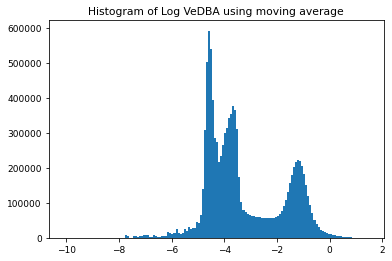

In [71]:
df = pd.read_csv('ACC Combined Data Rolling.csv',usecols=['VeDBA'])
plt.figure()
plt.title("Histogram of Log VeDBA using moving average")
plt.hist(np.log(df['VeDBA'].loc[df['VeDBA']>1e-6]),bins=150)
plt.show()

# Group Level VeDBA

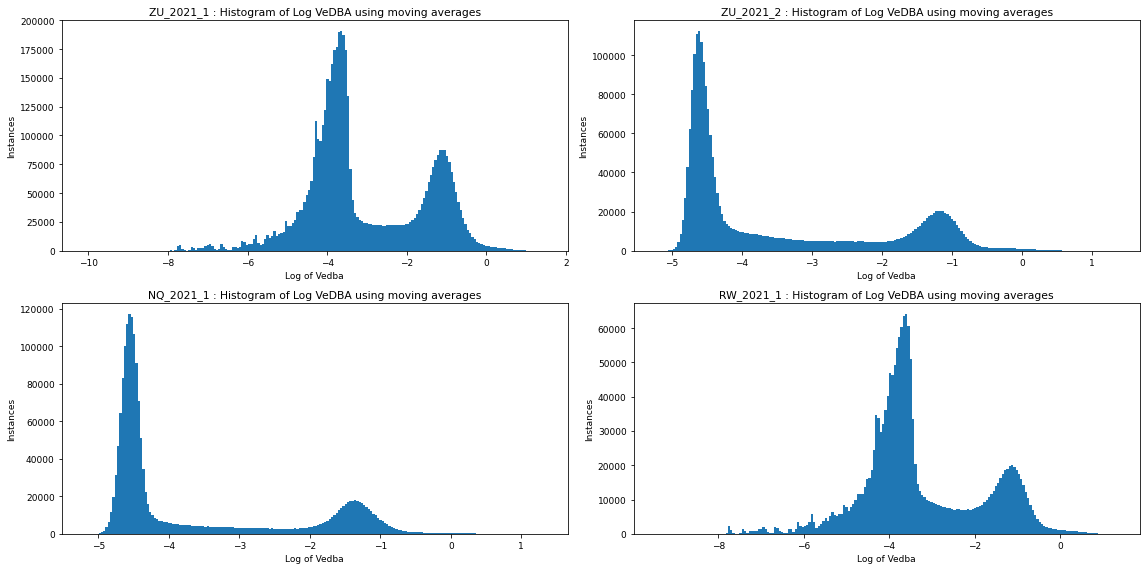

In [60]:
plt.rcParams.update({'font.size':10})
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(16,8))
Axes = axs.reshape(-1)
MainPath = 'Processed Data/'

Groups = ['ZU_2021_1','ZU_2021_2','NQ_2021_1','RW_2021_1']
for j in range(len(Groups)):
    
    paths = os.listdir(MainPath + Groups[j] + '/ACC/')

    df = pd.DataFrame(columns=['VeDBA'])

    for y in paths:

        File = str(y)
        
        Data = pd.read_csv(MainPath + Groups[j] + '/ACC/'+ File,usecols = ['VeDBA']) 

        df = pd.concat([df, Data], ignore_index=True, sort=False)

    Axes[j].hist(np.log(df['VeDBA'].loc[df['VeDBA']>1e-5]),bins=200)
    Axes[j].set_title(Groups[j] + ' : Histogram of Log VeDBA using moving averages')
    Axes[j].set_xlabel('Log of Vedba')
    Axes[j].set_ylabel('Instances')
    
fig.tight_layout()

# Individual VeDBA

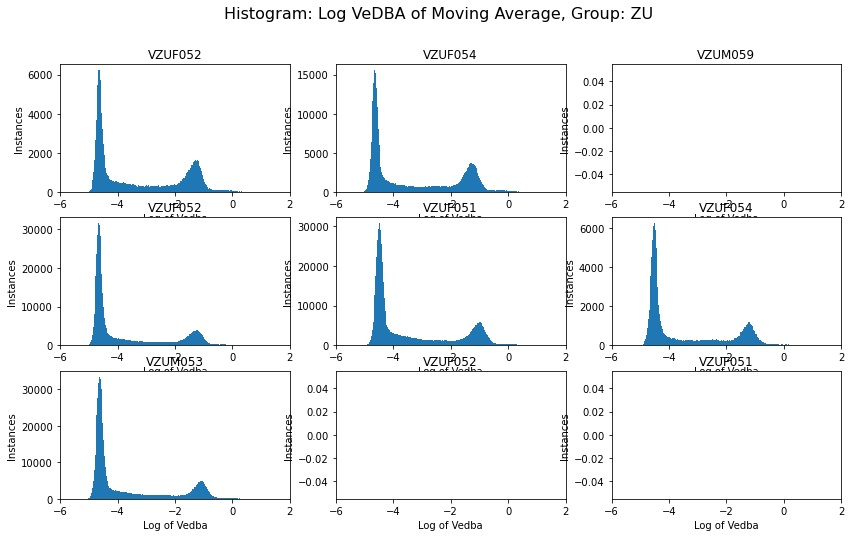

In [72]:
plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(nrows=3, ncols=3,figsize=(14,8))
Axes = axs.reshape(-1)

MainPath = 'Processed Data/ZU_2021_2/ACC/'

paths = os.listdir(MainPath)

df = pd.DataFrame(columns=['VeDBA'])

for y in paths:
    
    File = str(y)
    Data = pd.read_csv(MainPath + File,usecols = ['VeDBA']) 

    fig_det = y.split('_')

    fig.suptitle('Histogram: Log VeDBA of Moving Average, Group: '+str(fig_det[0]), fontsize=16)

    i = paths.index(y)

    Axes[i].hist(np.log(Data['VeDBA'].loc[Data['VeDBA']>1e-5]),bins=200)
    Axes[i].set_xlim([-6, 2])
    Axes[i].set_title( str(fig_det[1]))
    Axes[i].set_xlabel('Log of Vedba')
    Axes[i].set_ylabel('Instances')
    